In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/expression/"

In [13]:
df = pd.read_csv("../analysis/CLEAN_ASVs_counts_merged.tsv", sep = "\t")
df.columns = ["Sample_ID"] + list(df.columns[1:])
metadata = pd.read_csv("../metadata_rapaInter.csv")

In [14]:
## Log2 transform
log2otu_table = df.apply(np.log2)
log2otu_table = log2otu_table.replace(-np.inf, np.nan)

# Center to z-score
# Store the zscore per value of the log2intensity dataframe
sd_samp = []
mean_samp = []
df1 = pd.DataFrame()

for col in log2otu_table.columns:
    df1[col] = (log2otu_table[col] - log2otu_table[col].dropna().mean())/log2otu_table[col].dropna().std(ddof=0)
    sd_samp.append(log2otu_table[col].dropna().std())
    mean_samp.append(log2otu_table[col].dropna().mean())

# Get the SD and mean values per sample so we have them for normalizing.
scale_mean = np.nanmean(mean_samp)
scale_sd = np.nanmean(sd_samp)
    
norm_otu = pd.DataFrame()

# Normalize

for col in log2otu_table.columns:
    norm_otu[col] = (df1[col] * scale_sd) + scale_mean

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log2 method

In [2]:
norm_otu.to_csv("../analysis/norm-CLEAN_ASVs_counts_merged_{}.tsv".format(new_day), sep = "\t")

NameError: name 'norm_otu' is not defined

In [3]:
norm_otu = pd.read_csv("../analysis/norm-CLEAN_ASVs_counts_merged_20240530.tsv", sep = "\t")

In [6]:
# Sort metadata according to columnames to help understand groups
sorter = list(norm_otu.columns[1:])
metadata.Sample_ID = metadata.Sample_ID.astype("category")
metadata.Sample_ID = metadata.Sample_ID.cat.set_categories(sorter)
metadata = metadata.sort_values(["Sample_ID"])
metadata.set_index("Sample_ID", inplace = True)

# Transpose df and merge with metadata
expr = pd.merge(norm_otu.T, metadata, left_index = True, right_index = True)

In [7]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [19]:
# Get otus to show
ots = {}

for e in ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']:
    ots[e] = list(mer[mer["Genus"] == e]["OTU"].unique())
    print(e)
    display(mer[mer["Genus"] == e].loc[:, ["log2FoldChange", "padj", "Comparison", "Age", "Sex", "OTU"]])

Candidatus_Arthromitus


,log2FoldChange,padj,Comparison,Age,Sex,OTU
540,4.676004,0.026683,SexRapaEarly,Old,20240404.csv,ASV_694
1210,5.191363,0.038460,RapaLateRapaEarly,Old,M,ASV_694
1948,-4.466720,0.036402,RapaAdultRapaEarly,Mid,F,ASV_694


Lachnospiraceae_UCG-001


,log2FoldChange,padj,Comparison,Age,Sex,OTU
16,3.366254,2.723452e-07,RapaAdultRapaEarly,Mid,ALL,ASV_20
27,3.050459,1.870466e-05,RapaAdultRapaEarly,Mid,ALL,ASV_55
134,-2.931407,2.790862e-02,ControlRapaAdult,Mid,M,ASV_20
142,-3.256431,1.694481e-02,ControlRapaAdult,Mid,M,ASV_55
308,-1.983771,4.510583e-02,ControlRapaAdult,Young,ALL,ASV_20
320,-1.990165,4.257813e-02,ControlRapaAdult,Young,ALL,ASV_55
454,10.909310,2.203003e-05,SexRapaEarly,Old,20240404.csv,ASV_133
490,8.012223,3.501162e-04,SexRapaEarly,Old,20240404.csv,ASV_279
523,5.820319,4.031177e-03,SexRapaEarly,Old,20240404.csv,ASV_425
636,-7.263811,1.916886e-03,SexRapaAdult,Young,20240404.csv,ASV_341


Ruminiclostridium_5


,log2FoldChange,padj,Comparison,Age,Sex,OTU
88,2.533444,1.137231e-02,RapaAdultRapaEarly,Mid,ALL,ASV_375
126,6.808632,5.577241e-08,ControlRapaLate,Old,F,ASV_375
163,3.119816,2.553304e-02,ControlRapaAdult,Mid,M,ASV_216
184,-3.834853,1.321732e-02,ControlRapaAdult,Mid,M,ASV_375
259,2.479351,1.011056e-03,ControlRapaAdult,Old,F,ASV_216
285,3.954017,3.266018e-02,ControlRapaAdult,Old,F,ASV_375
474,-3.642751,1.264471e-04,SexRapaEarly,Old,20240404.csv,ASV_216
674,6.531163,2.165686e-02,SexControl,Old,20240404.csv,ASV_375
865,1.941352,1.325468e-02,ControlRapaEarly,Old,F,ASV_216
1013,1.804813,3.458679e-02,ControlRapaAdult,Mid,ALL,ASV_216


Lachnoclostridium


,log2FoldChange,padj,Comparison,Age,Sex,OTU
47,1.484428,8.831123e-03,RapaAdultRapaEarly,Mid,ALL,ASV_138
52,1.715154,8.282022e-03,RapaAdultRapaEarly,Mid,ALL,ASV_167
64,2.230852,4.107838e-06,RapaAdultRapaEarly,Mid,ALL,ASV_220
73,6.416977,8.136166e-05,RapaAdultRapaEarly,Mid,ALL,ASV_276
86,1.908612,1.021823e-02,RapaAdultRapaEarly,Mid,ALL,ASV_353
...,...,...,...,...,...,...
1979,2.127236,1.260363e-02,RapaAdultRapaEarly,Old,ALL,ASV_167
1987,1.768067,5.188694e-03,RapaAdultRapaEarly,Old,ALL,ASV_220
1991,6.575629,6.564866e-05,RapaAdultRapaEarly,Old,ALL,ASV_276
2107,8.516022,4.290231e-07,RapaAdultRapaEarly,Old,M,ASV_276


Lachnospiraceae_NK4A136_group


,log2FoldChange,padj,Comparison,Age,Sex,OTU
1,-10.759683,2.384571e-03,ControlRapaEarly,Mid,F,ASV_46
4,-3.195846,2.384571e-03,ControlRapaEarly,Mid,F,ASV_163
21,1.654163,1.137231e-02,RapaAdultRapaEarly,Mid,ALL,ASV_31
30,-1.593766,8.136166e-05,RapaAdultRapaEarly,Mid,ALL,ASV_71
61,-1.758083,3.076883e-04,RapaAdultRapaEarly,Mid,ALL,ASV_210
...,...,...,...,...,...,...
2093,9.298480,5.380683e-05,RapaAdultRapaEarly,Old,M,ASV_84
2095,-27.268458,1.002308e-33,RapaAdultRapaEarly,Old,M,ASV_127
2122,1.509208,3.887323e-02,ControlRapaAdult,Young,F,ASV_12
2138,3.799291,3.878910e-02,ControlRapaAdult,Young,F,ASV_127


In [35]:
palettesex = {'Control': '#000000',
 'Rapa Adult': '#c34e0d',
 'Rapa Early': '#5a9f68',
 'Rapa Late': '#4170b0'}

def plot_expression(bacteria):

    df = expr.loc[:, ots[bacteria] + ["Sex", "Treatment", "Age"]]

    ax = sns.boxplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment", palette = palettesex, 
               order = ["Young", "Mid", "Old"], showfliers = False)

    ax = sns.swarmplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment",
                          dodge = True, color = ".25", ax = ax, order = ["Young", "Mid", "Old"])

    plt.xlabel("Age Group")
    plt.ylabel(f"Z-score abundance ({bacteria} {ots[bacteria][0]})")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.show()

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


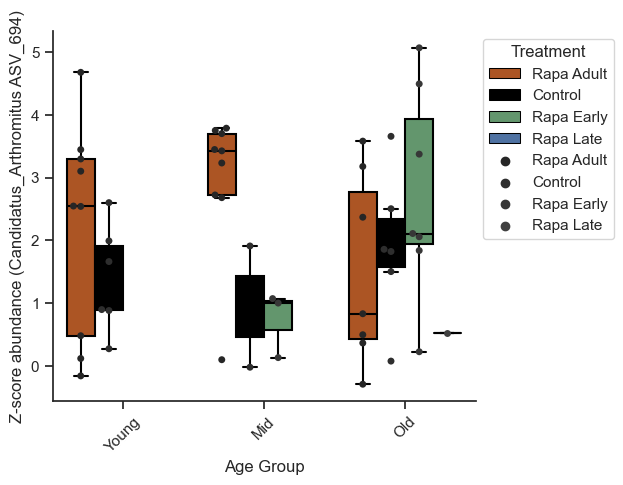

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


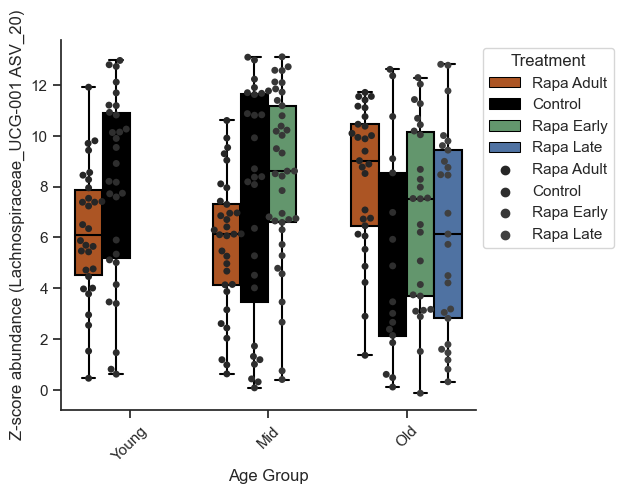

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


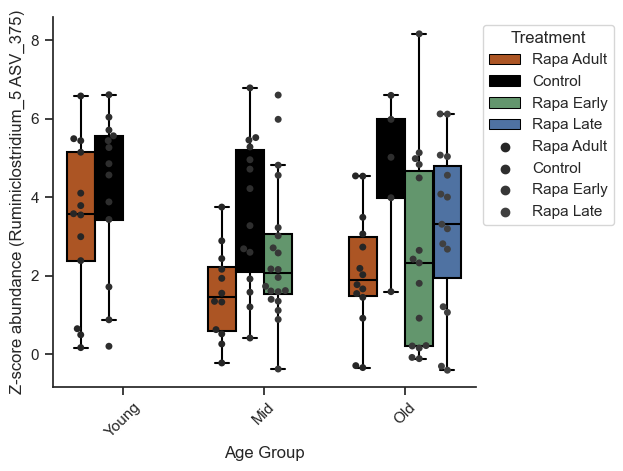

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


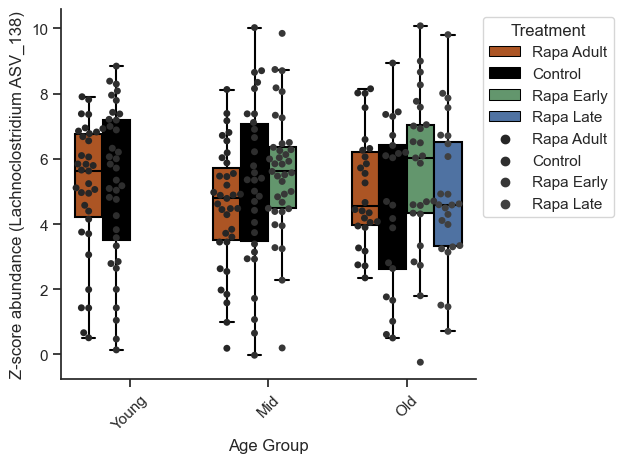

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


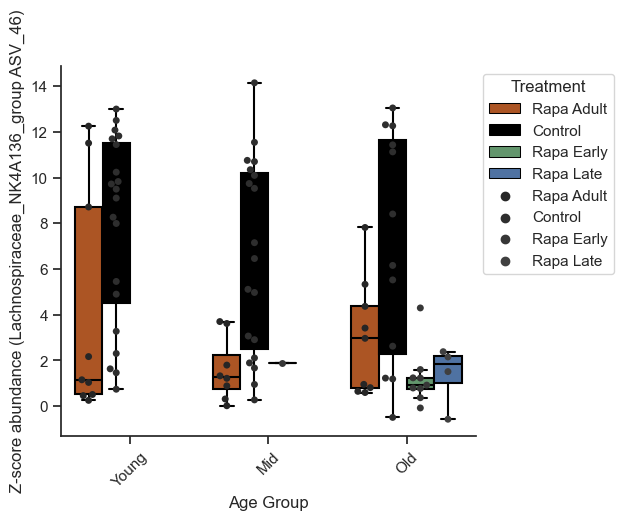

In [36]:
for e in ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']:
    plot_expression(e)

In [8]:
# Get otus to show
ots = {}

for e in ["ASV_33", "ASV_378"]:
    ots[e] = list(mer[mer["OTU"] == e]["Genus"].unique())
    print(e)
    display(mer[mer["OTU"] == e].loc[:, ["log2FoldChange", "padj", "Comparison", "Age", "Sex", "Genus"]])

ASV_33


,log2FoldChange,padj,Comparison,Age,Sex,Genus
87,1.813410,3.469111e-03,AGE,Mid,Old,Parasutterella
238,1.301175,3.836839e-03,RapaAdultRapaEarly,Mid,ALL,Parasutterella
436,1.741069,4.524443e-03,AGE,MidRapa Adult,OldRapa Late,Parasutterella
557,-2.931820,5.335338e-06,ControlRapaAdult,Mid,M,Parasutterella
863,-2.372181,4.115311e-02,SexRapaEarly,Old,20240404.csv,Parasutterella
1299,-2.252496,3.611985e-02,AGEMales,Mid,Old,Parasutterella
1401,-1.539543,4.050308e-02,ControlRapaEarly,Mid,ALL,Parasutterella
1464,-2.621701,2.919787e-03,ControlRapaAdult,Mid,F,Parasutterella
1592,-1.911015,3.424773e-02,ControlRapaEarly,Mid,M,Parasutterella
1936,-2.825330,4.141216e-09,ControlRapaAdult,Mid,ALL,Parasutterella


ASV_378


,log2FoldChange,padj,Comparison,Age,Sex,Genus
100,3.486312,0.005786,AGE,Mid,Old,Romboutsia
204,-6.132132,0.000037,AGEMales,YoungRapa Adult,OldRapa Early,Romboutsia
398,-5.951085,0.000001,AGE,YoungRapa Adult,OldRapa Early,Romboutsia
604,-4.610795,0.035176,ControlRapaAdult,Mid,M,Romboutsia
1339,6.676734,0.000006,AGEMales,Mid,Old,Romboutsia
1619,-5.066251,0.012172,ControlRapaEarly,Mid,M,Romboutsia
2512,5.721499,0.001584,AGE,Young,Old,Romboutsia
2934,-6.055415,0.031968,SexRapaEarly,Mid,20240404.csv,Romboutsia
3448,5.377770,0.004078,AGEMales,MidRapa Adult,OldRapa Late,Romboutsia
